In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "20" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "20" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "20" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "20" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "20"

In [3]:
import lifesim
import numpy as np
import matplotlib.pyplot as plt
import corner
import matplotlib
from lifesim.util.radiation import black_body
from astropy import units as u
from copy import deepcopy
from tqdm import tqdm

In [4]:
bus_0 = lifesim.Bus()
bus_0.build_from_config(filename='/net/ipa-gate/export/ipa/quanz/user_accounts/fdannert/spie_22/40_experiments/S00_lifesim/S00_base_SAG13_April23.yaml')

bus_0.data.import_catalog(input_path='/net/ipa-gate/export/ipa/quanz/user_accounts/fdannert/spie_22/40_experiments/S00_lifesim/'
                                   'S00_base_SAG13_April23_catalog.hdf5',
                        noise_catalog=False)

Importing Catalog...
Beginning Import...
Import completed (Time: 27.040687799453735), changing string object types...
[Done] (Time: 0.32596492767333984)


In [5]:
bus_1 = lifesim.Bus()
bus_1.build_from_config(filename='/net/ipa-gate/export/ipa/quanz/user_accounts/fdannert/spie_22/40_experiments/S01_Lay/S01_base_SAG13_April23.yaml')

bus_1.data.import_catalog(input_path='/net/ipa-gate/export/ipa/quanz/user_accounts/fdannert/spie_22/40_experiments/S01_Lay/'
                                   'S01_base_SAG13_April23_catalog.hdf5',
                        noise_catalog=True)

Importing Catalog...
Beginning Import...
Import completed (Time: 5.564907550811768), changing string object types...
[Done] (Time: 0.12275552749633789)
Importing Noise Catalog...
[Done]


In [6]:
ana = lifesim.SampleAnalysisModule(name='ana')
bus_1.add_module(ana)

In [7]:
ana.get_fundamental_snr()

### Compare the delta SNR for all relevant system parameters

In [8]:
bus_0.data.catalog = bus_0.data.catalog.sort_values('id')
bus_1.data.catalog = bus_1.data.catalog.sort_values('id')
bus_0.data.catalog = bus_0.data.catalog.set_index('id')
bus_1.data.catalog = bus_1.data.catalog.set_index('id')

In [9]:
bins = np.logspace(int(np.log10(bus_0.data.catalog.z.min())), 
                   np.log10(bus_0.data.catalog.z.max()), 
                   60, 
                   endpoint=True)
bins_mid = bins[1:]-bins[:-1]
upper = np.zeros_like(bins_mid)
lower = np.zeros_like(bins_mid)

delta_snr = ((bus_0.data.catalog['snr_1h'].to_numpy() - bus_1.data.catalog['snr_1h_prt'].to_numpy()) 
             / (bus_0.data.catalog['snr_1h'].to_numpy() + bus_1.data.catalog['snr_1h_prt'].to_numpy()) 
             * 2)

ez_z = bus_0.data.catalog.z

for i in range(len(bins_mid)):
    mask = np.logical_and(ez_z > bins[i], ez_z <= bins[i+1])
    upper[i] = np.median(delta_snr[np.logical_and(mask, delta_snr >= 0)])
    lower[i] = np.median(delta_snr[np.logical_and(mask, delta_snr < 0)])

/home/ipa/quanz/user_accounts/fdannert/spie_22/30_venv_spie/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipa/quanz/user_accounts/fdannert/spie_22/30_venv_spie/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


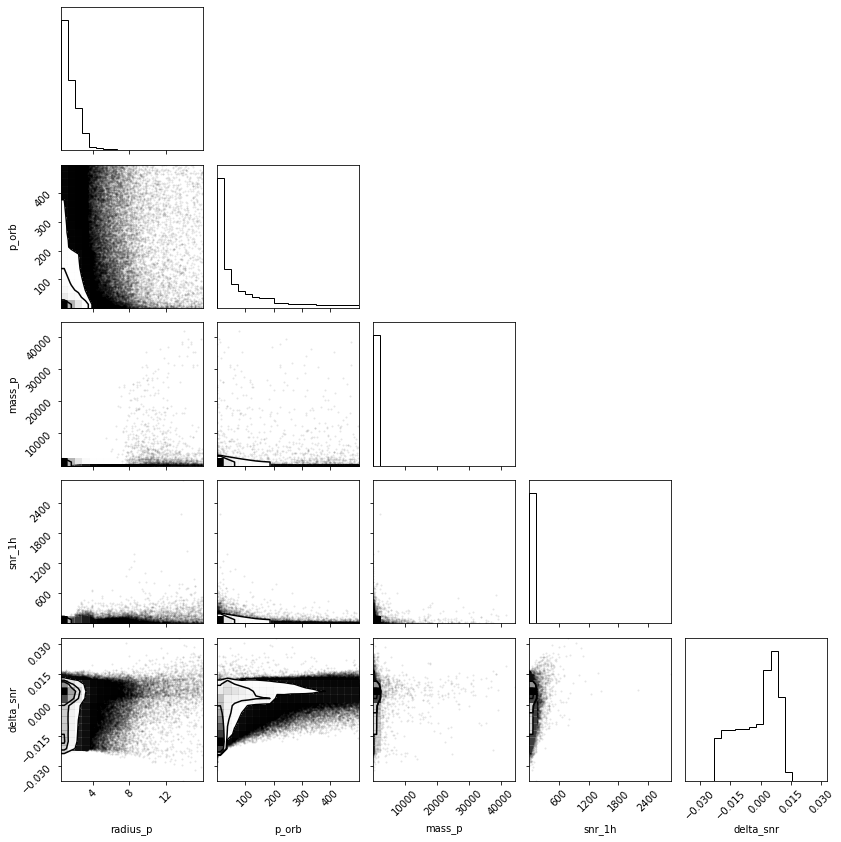

In [10]:
rel_param = ['radius_p', 'p_orb', 'mass_p', 'inc_p', 'large_omega_p',
       'small_omega_p', 'theta_p', 'albedo_bond', 'albedo_geom_vis',
       'albedo_geom_mir', 'z', 'semimajor_p', 'sep_p', 'angsep',
       'flux_p', 'fp', 'temp_p', 'radius_s', 'mass_s', 'temp_s', 'distance_s',
       'nuniverse', 'nstar', 'lon', 'lat',
       'hz_in', 'hz_out', 'hz_center', 
       'snr_1h', 'baseline']

rel_param = ['radius_p', 'p_orb', 'mass_p', 'snr_1h']
scale = ['log', 'log', 'log', 'log', 'linear']

%matplotlib inline

data = [bus_0.data.catalog[p] for p in rel_param]
data.append(delta_snr)
rel_param.append('delta_snr')
data = dict(zip(rel_param, data))
#data = np.vstack(data).T
figure = corner.corner(data=data,
                       axes_scale=scale,
                      labels=rel_param)
figure.tight_layout()
plt.show()

In [ ]:
for p in rel_param:
    fig, ax = plt.subplots(dpi=100, figsize=(10, 8))
    plt.scatter(bus_0.data.catalog[p], 
                delta_snr, 
                alpha=0.01)
    #plt.plot(bins_mid, upper, color='red', label='median')
    #plt.plot(bins_mid, lower, color='red')
    #plt.xscale('log')
    plt.xlabel(p)
    plt.ylabel('Relative SNR Deviation (base-inst)')
    plt.legend()
    points = fig.axes[0].collections[0]
    points.set_rasterized(True)
    plt.show()

### Analysis for Earth twin

In [11]:
def get_chi_delta(first, second):
    chi2 = ((first-second) / (first + second) / 2)**2
    return np.sum(chi2)

In [12]:
def plot_lifesim_difference(temp_p,
                           radius_p,
                           distance_s,
                           temp_s,
                           radius_s,
                           lat_s,
                           z,
                           angsep,
                           integration_time,
                           return_deltas=False,
                           plot=True):

    bus = lifesim.Bus()

    bus.data.options.set_scenario('baseline')
    bus.data.options.set_noise_scenario('lay')
    # bus.data.options.set_manual(flux_division=np.array((1, 1, 1, 1)))
    # bus.data.options.set_manual(quantum_eff=1.)
    # bus.data.options.set_manual(throughput=1)
    # bus.data.options.set_manual(diameter=1/np.sqrt(np.pi))

    instrument = lifesim.InstrumentPrt(name='inst')
    bus.add_module(instrument)

    instrument_base = lifesim.Instrument(name='inst_base')
    bus.add_module(instrument_base)

    transm = lifesim.TransmissionMap(name='transm')
    bus.add_module(transm)

    exo = lifesim.PhotonNoiseExozodi(name='exo')
    bus.add_module(exo)
    local = lifesim.PhotonNoiseLocalzodi(name='local')
    bus.add_module(local)
    star = lifesim.PhotonNoiseStar(name='star')
    bus.add_module(star)

    # connect all modules
    bus.connect(('inst_base', 'transm'))
    bus.connect(('inst_base', 'exo'))
    bus.connect(('inst_base', 'local'))
    bus.connect(('inst_base', 'star'))

    bus.connect(('star', 'transm'))

    bus.connect(('inst', 'inst_base'))

    instrument_base.apply_options()

    fgamma = (black_body(mode='planet',
                         bins=bus.data.inst['wl_bins'],
                         width=bus.data.inst['wl_bin_widths'],
                         temp=temp_p,
                         radius=radius_p,
                         distance=distance_s
                         )
              / bus.data.inst['wl_bin_widths']
              * u.photon / u.second / (u.meter ** 3))

    # fgamma = np.ones_like(bus.data.inst['wl_bins']) / bus.data.inst['wl_bin_widths'] * u.photon / u.second / (u.meter ** 3)

    flux_planet_spectrum = [bus.data.inst['wl_bins'] * u.meter, fgamma]

    res_in = instrument.get_spectrum(temp_s=temp_s,
                                     radius_s=radius_s,
                                     distance_s=distance_s,
                                     lat_s=lat_s,
                                     z=z,
                                     angsep=angsep,
                                     flux_planet_spectrum=flux_planet_spectrum,
                                     integration_time=integration_time)

    spectrum, flux_planet, noise = instrument_base.get_spectrum(temp_s=temp_s,
                                                                radius_s=radius_s,
                                                                distance_s=distance_s,
                                                                lat_s=lat_s,
                                                                z=z,
                                                                angsep=angsep,
                                                                flux_planet_spectrum=flux_planet_spectrum,
                                                                integration_time=integration_time,
                                                                safe_mode=True)
    # snr_in = res_in.loc['signal', 'chop'] / res_in.loc['fundamental', 'chop']
    print(bus.data.inst['bl'])
    snr_in = res_in.loc[:, 'signal'] / np.sqrt(res_in.loc[:, 'fundamental']**2 + res_in.loc[:, 'signal']*2)
    
    snr_in_tot = np.sqrt(np.sum(snr_in**2))
    snr_base_tot = np.sqrt(np.sum(spectrum[1]**2))
    delta_snr = ((snr_base_tot - snr_in_tot) 
             / (snr_base_tot + snr_in_tot) 
             * 2)
    
    if plot:
        fig, ax = plt.subplots(nrows=6, figsize=(4, 12))

        ax[0].plot(bus.data.inst['wl_bins'], snr_in, label='InLIFEsim')
        ax[0].plot(spectrum[0], spectrum[1], label='LIFEsim')
        ax[0].legend()
        ax[0].set_ylabel('SNR')

        ax[1].plot(bus.data.inst['wl_bins'], np.sqrt(res_in.loc[:, 'fundamental']**2 + res_in.loc[:, 'signal']*2), label='InLIFEsim')
        ax[1].plot(spectrum[0], np.sqrt(noise[0]), label='LIFEsim')
        ax[1].legend()
        ax[1].set_ylabel('Noise')

        ax[2].plot(bus.data.inst['wl_bins'], res_in.loc[:, 'signal'], label='InLIFEsim')
        ax[2].plot(spectrum[0], flux_planet, label='LIFEsim')
        ax[2].legend()
        ax[2].set_ylabel('Signal')

        ax[3].plot(bus.data.inst['wl_bins'], res_in.loc[:, 'pn_ez'], label='InLIFEsim')
        ax[3].plot(spectrum[0], np.sqrt(noise[2][0]*integration_time * bus.data.inst['eff_tot']), label='LIFEsim')
        ax[3].legend()
        ax[3].set_ylabel('Exozodi')

        ax[4].plot(bus.data.inst['wl_bins'], res_in.loc[:, 'pn_lz'], label='InLIFEsim')
        ax[4].plot(spectrum[0], np.sqrt(noise[1][0]*integration_time * bus.data.inst['eff_tot']), label='LIFEsim')
        ax[4].legend()
        ax[4].set_ylabel('Localzodi')

        ax[5].plot(bus.data.inst['wl_bins'], res_in.loc[:, 'pn_sgl'], label='InLIFEsim')
        ax[5].plot(spectrum[0], np.sqrt(noise[1][1]*integration_time * bus.data.inst['eff_tot']), label='LIFEsim', ls=':')
        ax[5].legend()
        ax[5].set_ylabel('Stellar Leakage')
        
        plt.tight_layout()
        text = ('LIFEsim SNR: ' + str(np.round(snr_base_tot, 5)) + 
                '\nInLIFEsim SNR: ' + str(np.round(snr_in_tot, 5)) + 
                '\nRelative SNR deviation: ' + str(np.round(delta_snr, 2)) +
               '\n\nPlanet temperature: ' + str(np.round(temp_p, 1)) + ' K\n' + 
                'Planet radius: ' + str(np.round(radius_p, 1)) + ' R_Earth\n' + 
                'Angular separation: ' + str(np.round(angsep, 1)) + ' arcsec\n\n' + 
                'Star temperature: ' + str(np.round(temp_s, 1)) + ' K\n' + 
                'Star radius: ' + str(np.round(radius_s, 1)) + ' R_Sun\n\n' +
                'Exozodi level: ' + str(np.round(z, 1)) + ' z\n\n' + 
                'Distance: ' + str(np.round(distance_s, 1)) + ' pc\n' )
        plt.figtext(1.05, 0.99, text, wrap=True, ha='left', va='top', fontsize=10)
        plt.show()
    
    if return_deltas:
        delta = {}
        delta['snr'] = delta_snr
        
        delta['signal'] = get_chi_delta(flux_planet, res_in.loc[:, 'signal'])
        delta['ez'] = get_chi_delta(np.sqrt(noise[2][0]*integration_time * bus.data.inst['eff_tot']), 
                                    res_in.loc[:, 'pn_ez'])
        delta['lz'] = get_chi_delta(np.sqrt(noise[1][0]*integration_time * bus.data.inst['eff_tot']), 
                                    res_in.loc[:, 'pn_lz'])
        delta['sgl'] = get_chi_delta(np.sqrt(noise[1][1]*integration_time * bus.data.inst['eff_tot']), 
                                    res_in.loc[:, 'pn_sgl'])
        return delta

14.549249638834699


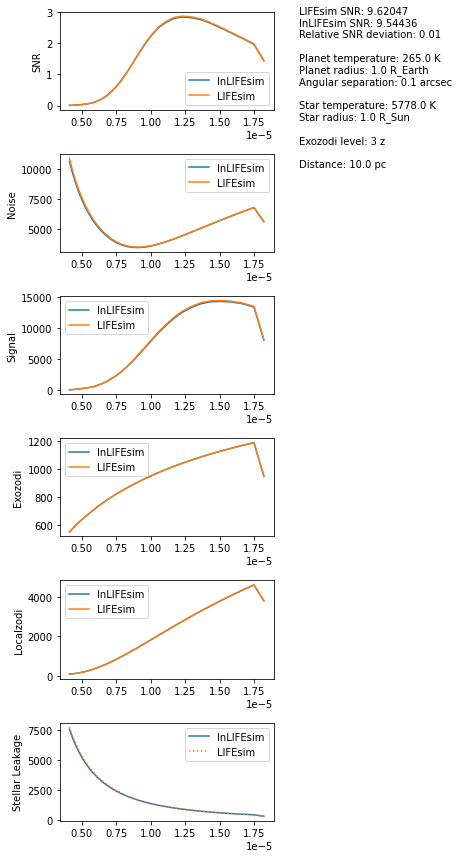

In [13]:
plot_lifesim_difference(temp_p = 265.,
                        radius_p = 1.,
                        distance_s = 10.,
                        temp_s = 5778.,
                        radius_s = 1.,
                        lat_s = 0.79,
                        z = 3,
                        angsep = 0.1,
                        integration_time = 55*60*60)

### Analysis for worst delta SNRs

27.587298437291764


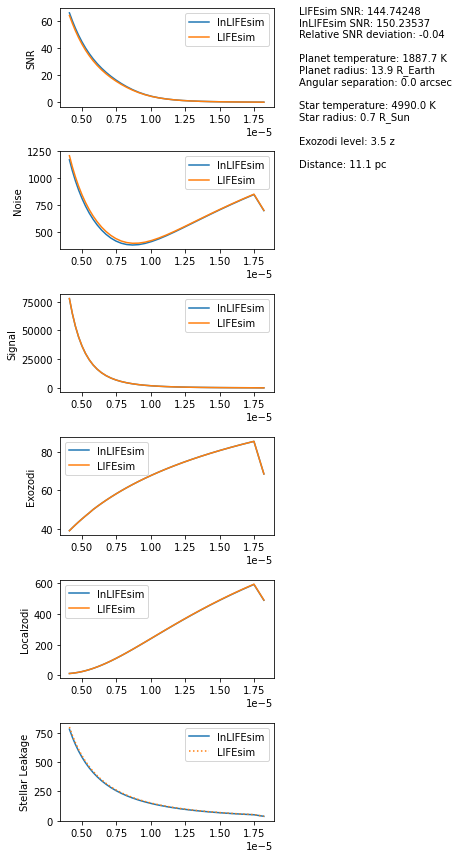

In [14]:
planet = bus_0.data.catalog.iloc[np.argmax(np.abs(delta_snr))]
plot_lifesim_difference(temp_p=planet['temp_p'],
                        radius_p=planet['radius_p'],
                        distance_s=planet['distance_s'],
                        temp_s=planet['temp_s'],
                        radius_s=planet['radius_s'],
                        lat_s=planet['lat'],
                        z=planet['z'],
                        angsep=planet['angsep'],
                        integration_time=60*60)

10.0


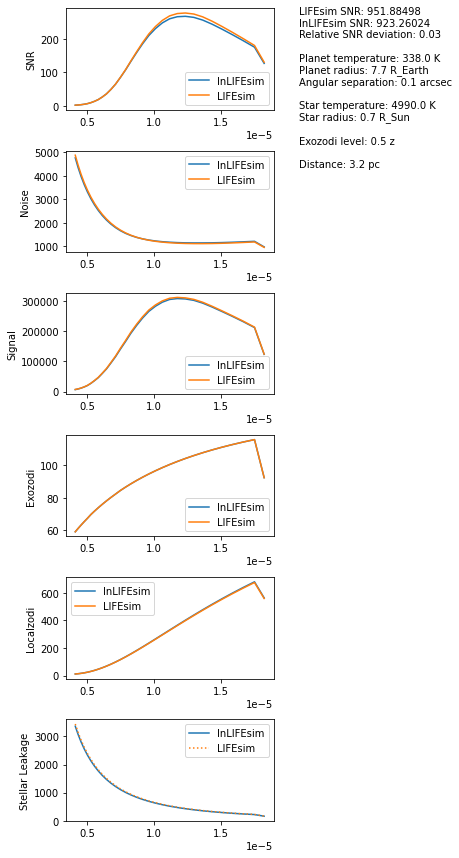

In [16]:
temp = deepcopy(delta_snr)
temp[np.argmax(temp)] = np.min(temp)
ind=np.argmax(temp)

planet = bus_0.data.catalog.iloc[ind]
plot_lifesim_difference(temp_p=planet['temp_p'],
                        radius_p=planet['radius_p'],
                        distance_s=planet['distance_s'],
                        temp_s=planet['temp_s'],
                        radius_s=planet['radius_s'],
                        lat_s=planet['lat'],
                        z=planet['z'],
                        angsep=planet['angsep'],
                        integration_time=60*60)

27.587298437291764


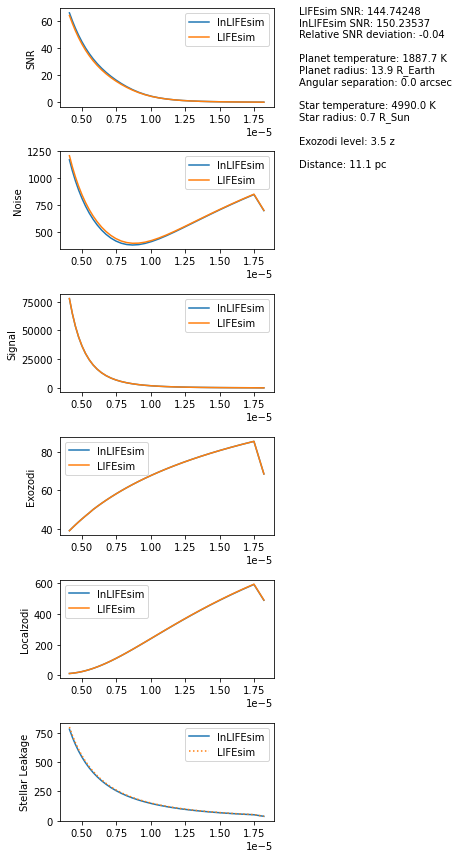

In [17]:
planet = bus_0.data.catalog.iloc[np.argmin(delta_snr)]
plot_lifesim_difference(temp_p=planet['temp_p'],
                        radius_p=planet['radius_p'],
                        distance_s=planet['distance_s'],
                        temp_s=planet['temp_s'],
                        radius_s=planet['radius_s'],
                        lat_s=planet['lat'],
                        z=planet['z'],
                        angsep=planet['angsep'],
                        integration_time=60*60)

### Where does the discrepancy come from?

In [18]:
noise_rel = {'pn_sgl': 2,
            'pn_lz': 1,
            'pn_ez': 0}

bus_0.data.catalog['d_pn_sgl'] = 0
bus_0.data.catalog['d_pn_lz'] = 0
bus_0.data.catalog['d_pn_ez'] = 0
bus_0.data.catalog['d_signal'] = 0

for i in tqdm(bus_1.data.catalog.index.values):

    for k in noise_rel.keys():
        n_base = np.sqrt(bus_0.data.catalog.loc[idx, 'noise_astro'][noise_rel[k]]* 60 * 60 * 0.035)
        n_inst = bus_1.data.noise_catalog.loc[idx, :, k] * np.sqrt(60 * 60 / 50000)
        chi2 = ((n_base-n_inst) / (n_base + n_inst) / 2)
        bus_0.data.catalog.loc[i, 'd_' + k] = float(np.sum(chi2))

    f_base = bus_0.data.catalog.loc[idx, 'flux_planet']
    f_inst = bus_1.data.noise_catalog.loc[idx, :, 'signal']*60*60/50000
    chi2 = ((f_base-f_inst) / (f_base + f_inst) / 2)
    bus_0.data.catalog.loc[i, 'd_signal' + k] = float(np.sum(chi2))

  0%|                                                                                                                                                  | 0/764515 [00:00<?, ?it/s]


NameError: name 'idx' is not defined

In [30]:
bus_1.data.noise_catalog = bus_1.data.noise_catalog.sortby('ids')
noise_rel = {'pn_sgl': 2,
            'pn_lz': 1,
            'pn_ez': 0}
bus_0.data.catalog['d_snr'] = delta_snr

for k in noise_rel.keys():
    #n_base = np.sqrt(bus_0.data.catalog.loc[idx, 'noise_astro'][noise_rel[k]]* 60 * 60 * 0.035)
    n_base = np.sqrt(np.stack(bus_0.data.catalog['noise_astro'].to_numpy())[:, noise_rel[k], :] * 60 * 60 * 0.035)
    n_inst = bus_1.data.noise_catalog.loc[:, :, k].to_numpy() * np.sqrt(60 * 60 / 50000)
    chi2 = ((n_base-n_inst) / (n_base + n_inst) * 2)**2
    bus_0.data.catalog['d_' + k] = np.sum(chi2, axis=1)
    
f_base = np.stack(bus_0.data.catalog['flux_planet'].to_numpy())
f_inst = bus_1.data.noise_catalog.loc[:, :, 'signal'].to_numpy() * 60 * 60 / 50000
chi2 = ((f_base-f_inst) / (f_base + f_inst) * 2)**2
bus_0.data.catalog['d_signal'] = np.sum(chi2, axis=1)

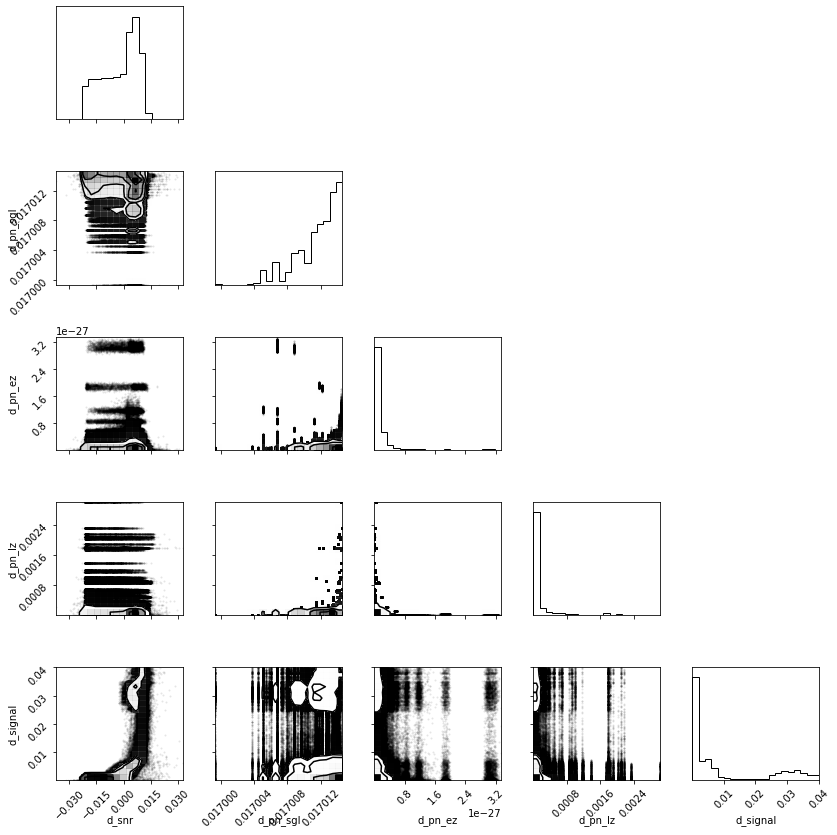

In [31]:
rel_param = ['d_snr', 'd_pn_sgl', 'd_pn_ez', 'd_pn_lz', 'd_signal']
#rel_param = ['d_snr', 'd_signal']
scale = ['linear', 'linear', 'linear', 'linear', 'log']

%matplotlib inline

data = [bus_0.data.catalog[p] for p in rel_param]
data = dict(zip(rel_param, data))
#data = np.vstack(data).T
figure = corner.corner(data=data,
                       axes_scale=scale,
                      labels=rel_param)
figure.tight_layout()
plt.show()

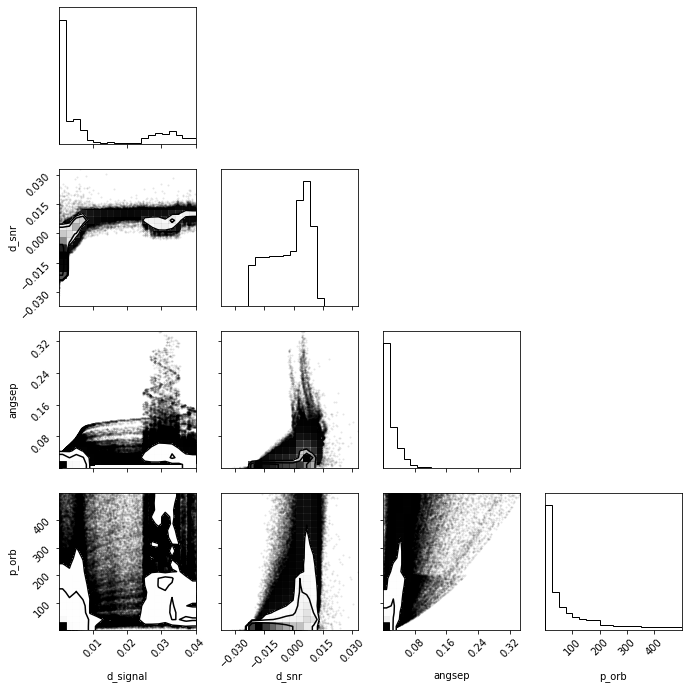

In [32]:
rel_param = ['d_snr', 'd_pn_sgl', 'd_pn_ez', 'd_pn_lz', 'd_signal']
rel_param = ['radius_p', 'p_orb', 'inc_p', 'z', 'angsep', 'temp_p', 'radius_s', 'mass_s', 'distance_s', 'lat',
       'snr_1h', 'd_signal', 'd_snr']
rel_param = ['d_signal', 'd_snr', 'angsep', 'p_orb']
#scale = ['linear', 'log']

%matplotlib inline

data = [bus_0.data.catalog[p] for p in rel_param]
data = dict(zip(rel_param, data))
#data = np.vstack(data).T
figure = corner.corner(data=data,
                       #axes_scale=scale,
                      labels=rel_param,
                      figsize=(10, 10))
figure.tight_layout()
plt.show()

44.95590401268807


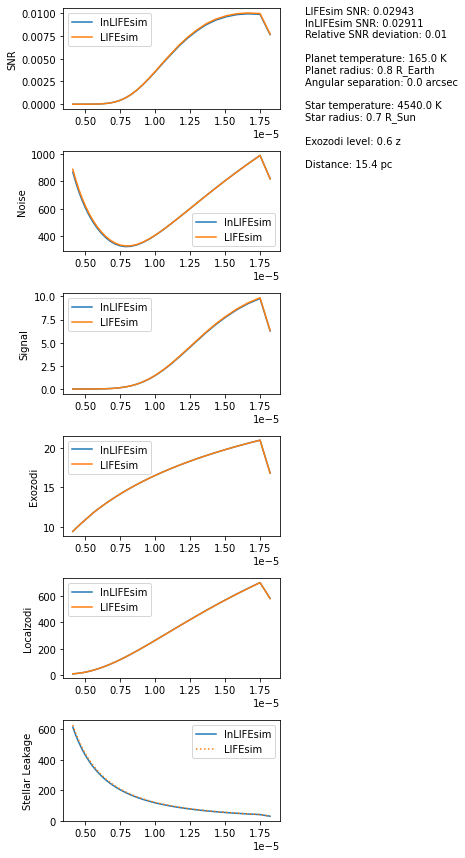

395


In [29]:
planet = bus_0.data.catalog.iloc[np.argmax(np.abs(bus_0.data.catalog['d_signal']))]
plot_lifesim_difference(temp_p=planet['temp_p'],
                        radius_p=planet['radius_p'],
                        distance_s=planet['distance_s'],
                        temp_s=planet['temp_s'],
                        radius_s=planet['radius_s'],
                        lat_s=planet['lat'],
                        z=planet['z'],
                        angsep=planet['angsep'],
                        integration_time=60*60)
print(planet['n_sampling_rot'])

### Looking at the angular separation

In [ ]:
planet = bus_0.data.catalog.iloc[np.argmax(np.abs(bus_0.data.catalog['d_signal']))]

angseps = np.linspace(0.01, 0.32, 20)

delta = []

for ang in tqdm(angseps):
    d = plot_lifesim_difference(temp_p=planet['temp_p'],
                        radius_p=planet['radius_p'],
                        distance_s=planet['distance_s'],
                        temp_s=planet['temp_s'],
                        radius_s=planet['radius_s'],
                        lat_s=planet['lat'],
                        z=planet['z'],
                        angsep=ang,
                        integration_time=60*60,
                               return_deltas=True,
                               plot=False)
    delta.append(d)

In [ ]:
signal = []
snr = []
for d in delta:
    signal.append(d['signal'])
    snr.append(d['snr'])

In [ ]:
fig, ax = plt.subplots()
plt.plot(signal, angseps, label='Signal')
plt.plot(snr, angseps, label='SNR')
plt.legend()
plt.xlabel('Delta')
plt.ylabel('Angular separation (arcsec)')
plt.title('Angular separation dependence for Wolf 359')
plt.show()

### Test the number of samples needed

#### For really bad planet

In [ ]:
planet

In [ ]:
planet = bus_0.data.catalog.iloc[np.argmax(np.abs(bus_0.data.catalog['d_signal']))]

freq = 2*np.pi*600/4e-6*planet['angsep'] * np.pi / 180 / 3600
print(freq)

freqs = (np.linspace(0.5, 10, 5) * freq).astype(int)

delta = []

for f in tqdm(freqs):
    d = plot_lifesim_difference(temp_p=planet['temp_p'],
                        radius_p=planet['radius_p'],
                        distance_s=planet['distance_s'],
                        temp_s=planet['temp_s'],
                        radius_s=planet['radius_s'],
                        lat_s=planet['lat'],
                        z=planet['z'],
                        angsep=planet['angsep'],
                        integration_time=60*60,
                               return_deltas=True,
                               plot=False,
                               n_sampling_rot=f)
    delta.append(d)

In [ ]:
signal = []
snr = []
for d in delta:
    signal.append(d['signal'])
    snr.append(d['snr'])
    
fig, ax = plt.subplots()
plt.plot(signal, freqs/freq, label='Signal')
plt.plot(snr, freqs/freq, label='SNR')
plt.legend()
plt.xlabel('Delta')
plt.ylabel('n_sampling_rot')
plt.title('Sampling rate dependence for Wolf 359')
plt.show()

#### For earth twin

In [ ]:
freq = 2*np.pi*14.549249638834699*6/4e-6*0.1 * np.pi / 180 / 3600

print(freq)

freqs = (np.linspace(0.5, 10, 10) * freq).astype(int)

delta = []

for f in tqdm(freqs):
    d = plot_lifesim_difference(temp_p=265,
                        radius_p=1,
                        distance_s=10,
                        temp_s=5778,
                        radius_s=1,
                        lat_s=0.78,
                        z=3,
                        angsep=0.1,
                        integration_time=60*60,
                               return_deltas=True,
                               plot=False,
                               n_sampling_rot=f)
    delta.append(d)

In [ ]:
signal = []
snr = []
for d in delta:
    signal.append(d['signal'])
    snr.append(d['snr'])
    
fig, ax = plt.subplots()
plt.plot(signal, freqs/freq, label='Signal')
plt.plot(np.abs(snr), freqs/freq, label='SNR')
plt.legend()
plt.xlabel('Delta')
plt.ylabel('n_sampling_rot')
plt.title('Sampling rate dependence for Earth Twin')
plt.xscale('log')
plt.show()

#### For random planet

In [ ]:
planet = bus_0.data.catalog.iloc[12367]

freq = 2*np.pi*600/4e-6*planet['angsep'] * np.pi / 180 / 3600
print(freq)

freqs = (np.linspace(0.5, 10, 20) * freq).astype(int)

delta = []

for f in tqdm(freqs):
    d = plot_lifesim_difference(temp_p=planet['temp_p'],
                        radius_p=planet['radius_p'],
                        distance_s=planet['distance_s'],
                        temp_s=planet['temp_s'],
                        radius_s=planet['radius_s'],
                        lat_s=planet['lat'],
                        z=planet['z'],
                        angsep=planet['angsep'],
                        integration_time=60*60,
                               return_deltas=True,
                               plot=False,
                               n_sampling_rot=f)
    delta.append(d)

In [ ]:
signal = []
snr = []
for d in delta:
    signal.append(d['signal'])
    snr.append(d['snr'])
    
fig, ax = plt.subplots()
plt.plot(signal, freqs/freq, label='Signal')
plt.plot(np.abs(snr), freqs/freq, label='SNR')
plt.legend()
plt.xlabel('Delta')
plt.ylabel('n_sampling_rot')
plt.title('Sampling rate dependence for BD-055715')
plt.xscale('log')
plt.show()

In [ ]:
plt.hist(bus_0.data.catalog.n_sampling_rot, bins=50)
plt.show()

### Compare the fourier transforms
nfft[10] in instrument.py

In [ ]:
fig, ax = plt.subplots(dpi=300)
plt.bar(np.arange(nfft_003.shape[0]), nfft_003, label='angsep = 0.03', alpha=0.5)
plt.bar(np.arange(nfft_020.shape[0]), nfft_020, label='angsep = 0.20', alpha=0.5)
plt.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(dpi=300)
plt.plot(n_planet_003, label='0.03 arcsec', lw=0.5)
plt.plot(n_planet_020, label='0.20 arcsec', lw=0.5)
plt.legend()
plt.show()

In [ ]:
nfft_020 = np.array([2.48116342e-09, 1.86763993e-10, 5.29341149e-10, 1.84387148e-10,
       1.09080607e-10, 1.62139138e-10, 3.70305543e-10, 1.40195790e-10,
       9.15630912e-11, 1.29560491e-10, 2.08101025e-10, 9.99532508e-11,
       2.38460398e-10, 5.93726126e-11, 3.27670549e-10, 3.81614697e-11,
       4.37577126e-10, 9.10962178e-12, 4.26882040e-10, 4.21944467e-11,
       4.41928598e-10, 5.88690910e-11, 2.58867620e-10, 4.79118059e-11,
       2.22049626e-10, 5.35415850e-11, 2.15714788e-10, 5.50114744e-11,
       4.51596691e-10, 1.06756657e-11, 4.33460785e-10, 8.83274321e-11,
       4.28716067e-10, 1.35635003e-10, 1.17444547e-10, 9.62344030e-11,
       5.18644310e-10, 2.30683436e-11, 6.09983082e-10, 6.96240193e-11,
       3.62139144e-10, 1.55912769e-10, 5.81165484e-10, 5.73891284e-11,
       4.62057685e-10, 1.73747175e-10, 4.75787824e-10, 2.02413165e-10,
       2.35348313e-10, 1.50644112e-10, 4.78536298e-10, 2.33857093e-10,
       2.07740438e-10, 2.38763995e-10, 4.01764853e-10, 1.01418114e-10,
       4.25534851e-10, 1.73341425e-10, 3.21847504e-10, 1.40240058e-10,
       4.55880123e-10, 1.24309400e-10, 4.08336534e-10, 1.34228502e-10,
       4.80865757e-10, 1.24695911e-10, 4.31702130e-10, 1.25280680e-10,
       5.43924715e-10, 1.46483350e-10, 3.10339054e-10, 1.07316992e-10,
       4.99308745e-10, 1.89740723e-10, 4.68871878e-10, 8.75385724e-11,
       7.36210809e-11, 1.46790361e-10, 5.34271956e-10, 2.09275694e-10,
       6.05948829e-10, 9.94408713e-11, 1.30365893e-10, 2.41276268e-10,
       5.70784450e-10, 2.96768088e-10, 7.01331365e-10, 2.94381869e-10,
       6.69206805e-10, 2.47750494e-10, 5.64700123e-10, 2.48071492e-10,
       3.26679945e-10, 3.88849270e-10, 1.85536158e-10, 1.54234235e-10,
       5.18769630e-10, 1.60001820e-10, 1.12678561e-10, 3.43069660e-10,
       1.63940257e-10, 6.26612823e-11, 2.35760103e-10, 2.45311864e-11,
       2.42756887e-10, 2.05513740e-10, 2.40254382e-10, 3.97569110e-11,
       3.63351142e-10, 2.46157309e-10, 3.64225047e-10, 1.32902244e-10,
       8.87826744e-12, 1.93948142e-11, 1.97987685e-10, 2.98172336e-11,
       2.51239083e-10, 1.23009700e-11, 3.16441005e-10, 3.49682604e-11,
       7.51963516e-12, 1.62526220e-10, 1.76402011e-10, 4.74648224e-11,
       2.37182564e-11, 1.14105684e-10, 2.82511668e-10, 1.55358880e-10,
       1.06903804e-10, 3.78136711e-10, 4.72513271e-11, 1.31543746e-10,
       4.03052642e-10, 1.39588931e-10, 3.93092897e-10, 1.06698708e-11,
       1.21433706e-11, 5.76936653e-10, 1.96601524e-10, 1.19088723e-10,
       4.88917729e-10, 7.05821475e-11, 1.15421623e-10, 2.04451684e-10,
       2.76786912e-10, 2.85238846e-10, 3.81703715e-10, 3.41763649e-11,
       1.72920567e-11, 4.98732633e-11, 3.47922400e-11, 7.78260724e-11,
       3.95046955e-10, 1.60187158e-10, 2.19757040e-10, 9.14913000e-11,
       1.93091312e-10, 1.00363237e-10, 8.55134682e-11, 2.12781269e-10,
       3.99412037e-10, 3.37906177e-11, 3.80468365e-13, 1.98982855e-10,
       8.99779755e-11, 4.43313470e-11, 1.60947685e-10, 1.50483141e-12,
       5.97581482e-10, 5.79279466e-11, 2.68707763e-10, 6.11836657e-10,
       6.11849640e-10, 1.71082820e-10, 2.63130764e-10, 4.87712108e-10,
       1.22402214e-10, 1.89680996e-10, 3.44831433e-10, 1.48319075e-10,
       1.56160981e-10])

In [ ]:
nfft_003 = np.array([1.98753269e-09, 3.14214398e-10, 1.06024504e-09, 3.42549549e-10,
       8.21707361e-10, 3.82243663e-10, 6.75377840e-11, 4.04165471e-10,
       1.04278833e-09, 3.65053865e-10, 8.14369940e-10, 2.47361709e-10,
       1.42620647e-09, 6.46666445e-11, 7.79430066e-10, 2.90531590e-10,
       2.50172403e-10, 5.79287779e-10, 7.49093433e-11, 7.51361055e-10,
       6.91601101e-11, 7.33912567e-10, 6.07299856e-11, 5.15845021e-10,
       3.97809978e-11, 2.03537391e-10, 3.95997876e-12, 8.08786872e-11,
       2.00477175e-11, 2.48803944e-10, 4.19052414e-11, 3.44807848e-10,
       5.06159621e-11, 3.97685450e-10, 6.22488747e-11, 3.58516236e-10,
       3.71986567e-11, 8.44910125e-11, 1.61437698e-11, 2.99696621e-10,
       7.64572732e-11, 4.02659909e-10, 4.12579289e-11, 1.63213315e-11,
       4.75422259e-11, 3.90599312e-10, 6.94538636e-11, 5.40298189e-11,
       6.90464740e-11, 5.56566847e-10, 1.12393031e-10, 1.88884756e-10,
       6.82081145e-11, 7.34805209e-10, 1.99072035e-10, 4.23903158e-10,
       6.74281246e-11, 8.13497870e-10, 2.30329130e-10, 4.82379315e-10,
       5.24431118e-11, 7.69208560e-10, 2.34636263e-10, 3.41739860e-10,
       9.80448058e-11, 6.64633694e-10, 1.42079689e-10, 6.87239378e-11,
       8.20528513e-11, 4.16137837e-10, 9.86142044e-11, 3.30904496e-11,
       1.16132049e-10, 3.16656197e-10, 1.26285927e-11, 2.63502814e-10,
       4.58071327e-11, 7.85499580e-11, 2.67525215e-11, 2.46465981e-11,
       2.40154959e-12, 8.02093650e-11, 1.60334408e-13, 1.24266508e-10,
       2.29886496e-11, 1.09937533e-10, 4.15669702e-11, 6.32089903e-11,
       4.63151380e-11, 1.96892068e-11, 4.11853212e-11, 6.12690620e-12,
       3.30157582e-11, 1.65799419e-11, 2.58428630e-11, 1.86545578e-11,
       2.07284511e-11, 1.75455179e-11, 1.73335787e-11, 1.57518479e-11,
       1.50566196e-11, 1.41151777e-11, 1.34465732e-11, 1.27901354e-11,
       1.22378497e-11, 1.17341490e-11, 1.12858191e-11, 1.08794556e-11,
       1.05103076e-11, 1.01731198e-11, 9.86362636e-12, 9.57858486e-12,
       9.31505058e-12, 9.07069973e-12, 8.84347121e-12, 8.63164295e-12,
       8.43370827e-12, 8.24836786e-12, 8.07448295e-12, 7.91105525e-12,
       7.75720355e-12, 7.61214734e-12, 7.47519231e-12, 7.34571858e-12,
       7.22317088e-12, 7.10705016e-12, 6.99690662e-12, 6.89233366e-12,
       6.79296282e-12, 6.69845937e-12, 6.60851849e-12, 6.52286203e-12,
       6.44123565e-12, 6.36340633e-12, 6.28916017e-12, 6.21830053e-12,
       6.15064632e-12, 6.08603050e-12, 6.02429880e-12, 5.96530855e-12,
       5.90892762e-12, 5.85503350e-12, 5.80351250e-12, 5.75425897e-12,
       5.70717468e-12, 5.66216816e-12, 5.61915425e-12, 5.57805354e-12,
       5.53879195e-12, 5.50130035e-12, 5.46551419e-12, 5.43137318e-12,
       5.39882098e-12, 5.36780495e-12, 5.33827587e-12, 5.31018777e-12,
       5.28349766e-12, 5.25816541e-12, 5.23415353e-12, 5.21142703e-12,
       5.18995331e-12, 5.16970197e-12, 5.15064472e-12, 5.13275531e-12,
       5.11600936e-12, 5.10038432e-12, 5.08585937e-12, 5.07241534e-12,
       5.06003467e-12, 5.04870132e-12, 5.03840070e-12, 5.02911969e-12,
       5.02084650e-12, 5.01357072e-12, 5.00728323e-12, 5.00197617e-12,
       4.99764295e-12, 4.99427820e-12, 4.99187777e-12, 4.99043869e-12,
       4.98995920e-12])

In [ ]:
n_planet_003 = np.array([1.04276419e-09, 2.06502344e-09, 1.33411363e-09, 1.03956468e-10,
       4.13706590e-10, 1.61256174e-09, 1.61141032e-09, 4.54027883e-10,
       3.87302256e-11, 8.28572446e-10, 1.30901028e-09, 6.99222537e-10,
       3.66249242e-11, 2.00234577e-10, 6.17777496e-10, 5.17869736e-10,
       1.29765361e-10, 2.97294413e-12, 9.45020262e-11, 1.01064201e-10,
       2.77381340e-11, 4.92654894e-13, 4.92126960e-13, 3.20949537e-11,
       1.36439145e-10, 1.67027421e-10, 2.94609261e-11, 9.91019778e-11,
       7.36607873e-10, 1.39396936e-09, 1.11064734e-09, 1.80021385e-10,
       2.87480787e-10, 2.19364889e-09, 4.09368667e-09, 3.58831732e-09,
       1.12716131e-09, 6.00241503e-11, 2.59182476e-09, 6.64220617e-09,
       7.90169439e-09, 4.88032753e-09, 8.71892845e-10, 4.20487372e-10,
       4.36148358e-09, 8.96860608e-09, 9.88990489e-09, 6.42651166e-09,
       1.85588548e-09, 2.50375673e-12, 1.82839429e-09, 5.11690144e-09,
       6.90703992e-09, 5.99543948e-09, 3.41831231e-09, 1.06288799e-09,
       4.48918947e-11, 1.85335566e-10, 6.28130261e-10, 7.32730366e-10,
       4.58667189e-10, 1.30754120e-10, 9.87306424e-13, 4.13699214e-11,
       7.12023256e-11, 1.61753567e-11, 4.13453391e-11, 4.58649898e-10,
       1.50155413e-09, 3.13929580e-09, 5.04861653e-09, 6.74455303e-09,
       7.78202184e-09, 7.92067114e-09, 7.18651267e-09, 5.82585557e-09,
       4.19341656e-09, 2.63102408e-09, 1.38048756e-09, 5.48849442e-10,
       1.20870176e-10, 2.47851250e-13, 5.86952198e-11, 1.77094913e-10,
       2.70846224e-10, 2.98573109e-10, 2.57812977e-10, 1.72994789e-10,
       8.07086063e-11, 1.59783824e-11, 1.80167322e-12, 4.30856714e-11,
       1.25417233e-10, 2.18736548e-10, 2.85687300e-10, 2.93912132e-10,
       2.30651278e-10, 1.16675171e-10, 1.51301706e-11, 2.99565559e-11,
       2.89104721e-10, 9.10788993e-10, 1.95687801e-09, 3.38533622e-09,
       5.02068121e-09, 6.56336114e-09, 7.65133214e-09, 7.96823341e-09,
       7.36671812e-09, 5.95434943e-09, 4.08882773e-09, 2.26032855e-09,
       8.96399818e-10, 1.81776895e-10, 2.72404549e-13, 4.95478858e-11,
       6.73942418e-11, 1.07392208e-11, 3.64293878e-11, 2.79750181e-10,
       6.25835621e-10, 7.38861839e-10, 4.22082646e-10, 1.95634198e-11,
       3.70891579e-10, 2.11201038e-09, 4.79472536e-09, 6.76617033e-09,
       6.33331463e-09, 3.49364765e-09, 5.40278154e-10, 4.40412295e-10,
       4.00273492e-09, 8.56530569e-09, 1.00475703e-08, 6.90164217e-09,
       1.99817488e-09, 2.34669789e-11, 2.67745222e-09, 6.81359689e-09,
       7.83156685e-09, 4.70358134e-09, 9.01912802e-10, 1.97564898e-10,
       2.42518181e-09, 4.20686700e-09, 3.32635768e-09, 1.07274831e-09,
       1.11663705e-12, 6.34212268e-10, 1.39696895e-09, 1.13254836e-09,
       3.55502470e-10, 2.40868159e-12, 1.07079405e-10, 1.75147308e-10,
       7.92687830e-11, 7.41428947e-12, 3.06692902e-17, 6.85185047e-12,
       6.38180395e-11, 1.16449276e-10, 4.42066247e-11, 2.07375974e-11,
       3.16972109e-10, 6.41465122e-10, 4.43840668e-10, 2.26320000e-11,
       2.86803987e-10, 1.10323616e-09, 1.20556149e-09, 3.57920118e-10,
       6.04286263e-11, 1.06339164e-09, 1.83337867e-09, 1.04769324e-09,
       3.06258297e-11, 6.17326268e-10, 1.91047603e-09, 1.72011833e-09,
       3.63291075e-10, 1.56011310e-10, 1.41547654e-09, 1.95205325e-09,
       8.68917897e-10, 1.89880100e-12, 6.76163569e-10, 1.57010959e-09,
       1.15163733e-09, 1.72641241e-10, 1.35109032e-10, 8.05355005e-10,
       9.19509105e-10, 3.47287017e-10, 8.40046851e-13, 1.82242193e-10,
       3.45007415e-10, 2.01913354e-10, 2.84154178e-11, 2.94383753e-12,
       9.93635875e-12, 3.16070358e-14, 1.41736310e-11, 7.16685475e-12,
       2.41423548e-11, 2.57354613e-10, 5.83127492e-10, 5.09943642e-10,
       7.34366037e-11, 2.10760579e-10, 1.43558827e-09, 2.58854749e-09,
       2.09020911e-09, 4.56992328e-10, 2.35587406e-10, 2.70461636e-09,
       5.63530581e-09, 5.63534316e-09, 2.52327950e-09, 5.26787586e-11,
       1.67746236e-09, 6.35112512e-09, 9.45486768e-09, 7.82466353e-09,
       3.14469885e-09, 8.80745052e-11, 1.51559919e-09, 5.87365473e-09,
       9.08074469e-09, 8.47932016e-09, 4.88815837e-09, 1.29040636e-09,
       8.53170625e-13, 1.04401456e-09, 2.75853988e-09, 3.52690463e-09,
       2.93864389e-09, 1.66829839e-09, 5.93210112e-10, 9.25273057e-11,
       5.68591360e-14, 4.21147646e-12, 6.43729677e-12, 1.49086331e-10,
       5.85893655e-10, 1.26004145e-09, 1.88502836e-09, 2.12434699e-09,
       1.81902321e-09, 1.10420538e-09, 3.53362156e-10, 7.91670619e-13,
       3.49461972e-10, 1.45637872e-09, 3.13074976e-09, 5.02254165e-09,
       6.74801674e-09, 7.99950217e-09, 8.60782251e-09, 8.55170951e-09,
       7.92743452e-09, 6.89958860e-09, 5.65205126e-09, 4.35119179e-09,
       3.12557686e-09, 2.06063372e-09, 1.20372649e-09, 5.74541620e-10,
       1.76588823e-10, 7.04830354e-12, 6.34820347e-11, 3.46785248e-10,
       8.60198522e-10, 1.60443417e-09, 2.56927642e-09, 3.72265002e-09,
       4.99923920e-09, 6.29215354e-09, 7.45240846e-09, 8.30129288e-09,
       8.65902090e-09, 8.38864325e-09, 7.44717886e-09, 5.92808364e-09,
       4.07413095e-09, 2.24221222e-09, 8.14968247e-10, 7.75753422e-11,
       1.03400804e-10, 7.05115011e-10, 1.49331674e-09, 2.03837690e-09,
       2.06918575e-09, 1.60142782e-09, 9.07239455e-10, 3.27909721e-10,
       4.75606333e-11, 2.87244027e-13, 3.32374004e-12, 1.68408399e-11,
       2.72374787e-10, 1.06712942e-09, 2.32758780e-09, 3.37655295e-09,
       3.31953694e-09, 1.93918438e-09, 3.14509369e-10, 2.99088403e-10,
       2.89967499e-09, 6.88847790e-09, 9.28567039e-09, 7.86158334e-09,
       3.57103577e-09, 2.36838524e-10, 1.13986482e-09, 5.58912540e-09,
       9.24429034e-09, 8.39365816e-09, 3.88932087e-09, 2.93447933e-10,
       9.18505961e-10, 4.29314420e-09, 6.12584497e-09, 4.35306556e-09,
       1.19501430e-09, 1.49823770e-11, 1.27409276e-09, 2.58249949e-09,
       2.14271486e-09, 7.20694288e-10, 5.25558393e-12, 2.91461318e-10,
       6.18897735e-10, 4.38329722e-10, 1.08052170e-10, 1.42774418e-13,
       1.62026741e-11, 5.21302462e-12, 3.44547106e-12, 1.02042682e-11,
       1.54765853e-12, 9.84005493e-11, 3.00952821e-10, 3.01255201e-10,
       5.19384740e-11, 9.84520649e-11, 6.66333404e-10, 9.80834935e-10,
       4.66672357e-10, 1.98000395e-13, 6.16494291e-10, 1.53272004e-09,
       1.23260329e-09, 1.77741535e-10, 2.65240817e-10, 1.53789360e-09,
       1.90581258e-09, 7.17610460e-10, 1.20339870e-11, 1.04276419e-09])

In [ ]:
planet_template_003 = np.array([ 1.82486184e-01,  5.12660497e-01, -2.63960553e-02, -4.96272180e-01,
       -1.15351112e-01,  4.36596717e-01,  2.41548083e-01, -3.06355025e-01,
       -2.91387605e-01,  1.87310601e-01,  3.09630255e-01, -3.96378279e-02,
       -2.36787543e-01, -2.83790235e-02,  1.67329944e-01,  8.36373870e-02,
       -6.19233081e-02, -4.94124874e-02,  1.93481790e-02,  2.58972671e-02,
        3.41108479e-03,  6.96308751e-04, -4.48536532e-03,  9.07272523e-03,
        2.94005566e-02, -3.16827906e-02, -1.55362465e-01, -9.45948137e-02,
        2.01251291e-01,  3.07035427e-01, -1.40755300e-01, -6.70845824e-01,
       -4.21741998e-01,  5.58028590e-01,  1.02216350e+00,  9.82865843e-02,
       -1.31994762e+00, -1.41341957e+00,  2.33901910e-01,  1.87461421e+00,
        1.51342476e+00, -6.71006365e-01, -2.40483582e+00, -1.78315739e+00,
        6.44945177e-01,  2.50836037e+00,  2.05771365e+00, -1.73843870e-01,
       -2.10846695e+00, -2.16142617e+00, -5.49485037e-01,  1.23012869e+00,
        1.85319186e+00,  1.17495222e+00,  1.19535898e-02, -7.26006787e-01,
       -7.39682145e-01, -3.23862423e-01,  5.38960997e-02,  1.74994905e-01,
        1.05963091e-01,  2.46647883e-02, -4.79874338e-03, -3.96123379e-02,
       -1.69582656e-01, -3.70087516e-01, -5.07568760e-01, -4.03757343e-01,
        1.69733783e-02,  6.85722303e-01,  1.38789702e+00,  1.88209549e+00,
        1.97888608e+00,  1.63265885e+00,  9.20501418e-01,  2.40100495e-02,
       -8.63967711e-01, -1.57195497e+00, -2.01171691e+00, -2.15724646e+00,
       -2.05680770e+00, -1.77932667e+00, -1.41628492e+00, -1.03422026e+00,
       -6.92683792e-01, -4.13577109e-01, -2.13549927e-01, -8.15450349e-02,
       -1.51376280e-02,  2.88205956e-03, -2.93909604e-02, -1.04855677e-01,
       -2.37129077e-01, -4.27100340e-01, -6.88669035e-01, -1.01100644e+00,
       -1.38293540e+00, -1.75583303e+00, -2.07450403e+00, -2.25080050e+00,
       -2.21113240e+00, -1.88662901e+00, -1.27343549e+00, -4.21069615e-01,
        5.27720396e-01,  1.39162595e+00,  1.96445592e+00,  2.11653411e+00,
        1.81874664e+00,  1.20135948e+00,  4.81775040e-01, -8.84619464e-02,
       -3.67606700e-01, -3.50795043e-01, -1.86759482e-01, -3.57997632e-02,
        8.57255628e-03,  6.01221707e-04,  2.31760269e-02,  9.25714851e-02,
        6.22973984e-02, -2.09497055e-01, -6.71951517e-01, -9.40448483e-01,
       -5.80808254e-01,  4.56454835e-01,  1.51163554e+00,  1.61529382e+00,
        3.26707766e-01, -1.56147192e+00, -2.46806498e+00, -1.36189811e+00,
        1.01501388e+00,  2.59078912e+00,  1.81907989e+00, -6.22577536e-01,
       -2.37054830e+00, -1.69773957e+00,  5.99037775e-01,  2.08289152e+00,
        1.30089623e+00, -6.37300562e-01, -1.52206557e+00, -5.75925012e-01,
        8.09454101e-01,  1.03364515e+00,  1.21478609e-01, -5.96395049e-01,
       -3.90726002e-01,  2.07078336e-01,  3.64347229e-01,  8.91332421e-02,
       -1.28880463e-01, -6.76780569e-02,  3.16729621e-02,  4.02645535e-02,
        2.56733316e-03,  3.65129280e-03, -6.08451524e-03,  9.37639393e-03,
        1.58741646e-02, -2.04873365e-02, -9.55944428e-02, -1.64454422e-02,
        1.29783987e-01,  8.67772406e-02, -1.90604924e-01, -2.07553085e-01,
        1.32365565e-01,  3.16755836e-01, -8.15283110e-02, -4.01465042e-01,
       -8.29820192e-02,  4.40999121e-01,  1.93899006e-01, -3.89473294e-01,
       -3.81411722e-01,  3.46847433e-01,  3.99336523e-01,  3.87988558e-04,
       -3.99836438e-01, -3.52545486e-01,  3.73828316e-01,  3.82237752e-01,
       -2.02671349e-01, -4.54039041e-01,  6.70865270e-02,  3.85613900e-01,
        6.56291628e-02, -3.34972132e-01, -1.52906908e-01,  1.86892944e-01,
        1.70954440e-01, -1.06300596e-01, -1.49480406e-01, -2.24052855e-03,
        7.91460187e-02,  6.53545078e-03, -2.70299977e-02, -1.69615762e-02,
        2.91188215e-03, -1.81351534e-03,  5.03853895e-03, -2.62769090e-02,
       -1.09756289e-02,  9.56199069e-02,  1.65228620e-01, -4.39287785e-02,
       -3.11423564e-01, -1.47647962e-01,  4.57735807e-01,  6.73004746e-01,
       -3.61651837e-02, -9.44402659e-01, -7.20260892e-01,  6.66011963e-01,
        1.61651324e+00,  7.35211639e-01, -1.20696667e+00, -2.00128296e+00,
       -5.31754531e-01,  1.75483507e+00,  2.42063577e+00,  6.61860567e-01,
       -1.79934318e+00, -2.59706743e+00, -1.04655634e+00,  1.31091699e+00,
        2.40272033e+00,  1.48234748e+00, -4.21890079e-01, -1.72749401e+00,
       -1.63762897e+00, -5.89640325e-01,  4.47787700e-01,  8.13486725e-01,
        5.55396645e-01,  1.07116330e-01, -1.46318565e-01, -1.53836492e-01,
       -5.77973541e-02, -6.10891301e-03,  1.59275034e-02,  8.97175264e-02,
        2.68417236e-01,  4.57376524e-01,  4.95095886e-01,  2.31346705e-01,
       -3.30338527e-01, -1.04927872e+00, -1.67424873e+00, -1.98758462e+00,
       -1.85804627e+00, -1.31347628e+00, -4.81925916e-01,  4.32035554e-01,
        1.24889346e+00,  1.82759745e+00,  2.12044007e+00,  2.13290114e+00,
        1.93544888e+00,  1.60289404e+00,  1.22436963e+00,  8.55483705e-01,
        5.44892597e-01,  3.03156822e-01,  1.40114479e-01,  4.03046892e-02,
        1.05596792e-03,  6.60327933e-03,  6.19278698e-02,  1.62906725e-01,
        3.24836414e-01,  5.48388571e-01,  8.43403693e-01,  1.19235376e+00,
        1.57311547e+00,  1.92629490e+00,  2.18613397e+00,  2.26219437e+00,
        2.08704565e+00,  1.61397354e+00,  8.70786150e-01, -5.25977112e-02,
       -9.82876075e-01, -1.72556553e+00, -2.09735762e+00, -2.01977602e+00,
       -1.53720406e+00, -8.38516111e-01, -1.65058202e-01,  2.67782509e-01,
        3.89951081e-01,  2.75535646e-01,  1.01527019e-01,  2.45686569e-04,
       -4.67498158e-03, -4.40221824e-03, -5.75974305e-02, -1.01823004e-01,
        3.98674600e-02,  4.33804720e-01,  8.61930350e-01,  8.56608231e-01,
        1.22018312e-01, -1.04443502e+00, -1.73341430e+00, -1.12633353e+00,
        6.36348579e-01,  2.23345106e+00,  2.16702212e+00,  2.15912296e-01,
       -2.03825385e+00, -2.51549751e+00, -6.75571820e-01,  1.73752983e+00,
        2.35128075e+00,  6.09460764e-01, -1.58760615e+00, -1.96315756e+00,
       -3.30993638e-01,  1.31664979e+00,  1.22800866e+00, -1.87523068e-01,
       -1.11158703e+00, -6.46020004e-01,  3.40393011e-01,  5.99172400e-01,
        7.78341314e-02, -3.63270902e-01, -2.50506340e-01,  5.37477026e-02,
        1.23386070e-01,  7.45368956e-03, -4.66832140e-02, -1.98427199e-02,
       -1.08817290e-04,  2.04053799e-05,  2.08418077e-03, -1.64445459e-02,
       -6.68657354e-03,  6.45807863e-02,  7.96169921e-02, -6.42922914e-02,
       -1.47601421e-01,  4.77795012e-02,  2.56972408e-01,  6.04648302e-02,
       -2.89982561e-01, -1.70540783e-01,  3.07088870e-01,  3.22380620e-01,
       -2.26576522e-01, -4.25925745e-01,  1.23046135e-01,  5.03533417e-01,
        3.37661158e-02, -5.09755828e-01, -1.83067599e-01,  1.82486184e-01])

In [ ]:
n_planet_020 = np.array([3.78790929e-09, 3.63973657e-09, 3.88340827e-09, 3.21715119e-09,
       3.59072469e-09, 2.67750915e-09, 2.81245355e-09, 2.01466038e-09,
       1.64480643e-09, 1.18108671e-09, 5.15968788e-10, 2.89664043e-10,
       8.56405608e-12, 1.09218704e-10, 1.03255137e-10, 2.21533066e-09,
       1.29992753e-11, 6.45268900e-09, 8.99380141e-10, 7.12659816e-09,
       5.30578485e-09, 1.77318310e-09, 5.96624774e-09, 1.12353101e-10,
       5.17242387e-10, 2.19972387e-11, 3.00147680e-11, 4.16809773e-09,
       4.71520579e-09, 2.16177653e-10, 7.43518825e-09, 4.61103002e-09,
       8.22342405e-11, 2.01661035e-12, 1.59458785e-09, 3.91105952e-09,
       6.19946170e-10, 1.43789817e-09, 4.21261011e-09, 1.39990623e-09,
       1.16900397e-10, 1.26815928e-09, 5.04269592e-10, 8.40369247e-11,
       8.34806186e-10, 3.82279386e-10, 2.10705958e-10, 2.93400499e-09,
       6.07276160e-09, 5.29405332e-09, 1.63393179e-09, 2.48074987e-12,
       7.32499537e-10, 3.36707023e-10, 1.94182223e-10, 8.77977698e-10,
       2.32528972e-11, 4.35033109e-09, 6.55325024e-09, 5.94446296e-10,
       3.36417215e-10, 7.13536700e-10, 4.52326411e-09, 8.76869493e-12,
       3.74157473e-09, 1.69600111e-11, 2.32115716e-10, 9.78591894e-09,
       5.54893028e-10, 6.73817151e-10, 4.37310201e-10, 6.84968974e-09,
       1.34308639e-09, 1.77639727e-09, 5.18674740e-14, 6.98578955e-09,
       4.24646716e-09, 3.17805102e-10, 5.04734174e-10, 4.13073508e-09,
       2.23472152e-12, 1.42814662e-09, 3.70989945e-10, 5.61354550e-09,
       3.11596121e-09, 8.74773601e-11, 1.21054446e-11, 1.33763417e-09,
       3.48740738e-09, 1.44297301e-09, 1.86084661e-10, 2.93804125e-09,
       2.72477062e-09, 3.21779984e-10, 1.68519411e-13, 9.38495588e-10,
       5.46529378e-09, 3.00800878e-09, 3.03457864e-10, 9.36187206e-10,
       1.68149878e-09, 3.16453105e-09, 1.39978002e-10, 2.10128114e-10,
       9.32348794e-09, 1.41318063e-09, 1.73620020e-11, 4.38206147e-09,
       1.07005164e-09, 5.02493195e-09, 6.53202500e-12, 3.12199189e-09,
       3.21489846e-09, 3.07532867e-09, 8.15889697e-10, 4.64668810e-12,
       6.00213101e-09, 7.60502708e-09, 1.00678360e-10, 1.76500051e-11,
       4.66277338e-09, 6.50858524e-09, 6.48184747e-10, 1.09484558e-10,
       3.64151015e-10, 5.67055110e-09, 1.01249158e-08, 6.01977219e-09,
       7.61233457e-10, 4.14845303e-10, 2.56873105e-09, 3.77741863e-09,
       3.04687562e-09, 1.06288045e-09, 3.17334060e-11, 2.73911930e-09,
       8.17437079e-09, 9.86979073e-09, 5.07091864e-09, 5.89003470e-10,
       9.75081151e-12, 2.81230391e-10, 4.74201274e-09, 1.00762818e-08,
       5.38656967e-09, 2.01462087e-10, 9.62621746e-11, 5.35179558e-10,
       2.40219974e-09, 2.03717404e-12, 6.46500424e-09, 8.28722922e-09,
       2.25843241e-10, 1.76175031e-09, 4.20623763e-10, 2.29008363e-14,
       1.48764694e-09, 2.23554016e-09, 1.53436352e-09, 9.23517948e-09,
       1.03866607e-10, 8.31656077e-09, 2.16537821e-09, 2.88472948e-09,
       2.06608868e-09, 3.53789051e-10, 3.69441085e-10, 6.16895878e-13,
       1.78043780e-10, 1.00739409e-11, 1.70439144e-09, 4.56131920e-13,
       3.77795914e-09, 6.53116722e-12, 5.56498277e-09, 1.53854984e-11,
       6.78573856e-09, 9.30429970e-12, 7.43400154e-09, 4.74432108e-13,
       7.56014138e-09, 3.94789865e-12, 7.17803796e-09, 1.39530594e-11,
       6.24968786e-09, 1.24830399e-11, 4.73470802e-09, 1.16078863e-12,
       2.74024921e-09, 5.27868913e-12, 7.96620024e-10, 6.13193199e-12,
       7.95778793e-12, 5.81068550e-11, 1.16897112e-09, 1.18960491e-09,
       2.53744540e-09, 5.47359552e-09, 1.07135039e-09, 1.00296801e-08,
       2.70376725e-10, 5.96417995e-09, 2.36760529e-09, 2.79418167e-10,
       1.20700612e-10, 8.20114871e-11, 1.19849135e-09, 6.28406410e-09,
       1.12687362e-09, 3.54357596e-09, 7.73853320e-09, 1.37079923e-09,
       2.60927621e-11, 2.75598260e-10, 3.36011843e-09, 2.56179527e-09,
       5.69309725e-11, 3.42538411e-09, 3.21807441e-09, 1.63030643e-10,
       7.83264717e-10, 1.09933480e-09, 4.86002415e-11, 4.87886163e-10,
       7.87540828e-10, 2.13221345e-11, 1.23032471e-09, 4.78085884e-09,
       6.27879651e-09, 3.50787740e-09, 3.62680564e-10, 3.22061659e-10,
       7.37338626e-10, 9.63997175e-12, 7.16858253e-10, 3.58616099e-10,
       1.31468518e-09, 6.94656788e-09, 3.41669349e-09, 3.88304745e-11,
       2.58728808e-11, 3.36755580e-09, 1.91573956e-09, 2.18385114e-09,
       1.58599752e-09, 1.15464360e-10, 4.36494566e-09, 6.58081968e-09,
       6.36389724e-10, 6.14125629e-11, 4.28225796e-10, 9.06676853e-09,
       1.05604410e-09, 2.87292616e-11, 2.70208356e-09, 6.72707658e-10,
       6.24078236e-09, 1.01713851e-10, 2.23234280e-10, 8.12950306e-09,
       6.00343143e-09, 7.96416895e-11, 8.43688820e-11, 4.25912670e-09,
       6.14509176e-09, 4.17988716e-10, 2.73950136e-09, 7.00461873e-09,
       4.10023209e-09, 2.02298073e-10, 1.70432043e-09, 6.28059674e-09,
       5.60979751e-09, 3.43949027e-10, 3.11914938e-09, 6.66399486e-09,
       1.34259751e-09, 7.74573911e-12, 1.66581301e-09, 9.70339213e-09,
       3.07584525e-09, 2.36155390e-11, 2.35871355e-09, 5.19917121e-09,
       8.25648965e-10, 9.50327387e-10, 1.03388984e-10, 7.44618044e-09,
       1.92744653e-09, 1.49716369e-09, 1.38308889e-10, 6.81558958e-09,
       2.82450976e-11, 3.65449644e-09, 8.75936486e-12, 1.09708605e-09,
       1.00234931e-08, 2.39727325e-09, 5.40750760e-11, 1.26114994e-09,
       7.36075641e-09, 3.21950799e-09, 3.77795615e-15, 8.49541426e-12,
       2.30343990e-09, 8.85715548e-09, 8.90736117e-09, 2.91259716e-09,
       3.91497354e-12, 1.44936364e-09, 3.40484883e-09, 3.64289551e-09,
       2.11303606e-09, 2.31621204e-10, 8.28261784e-10, 5.44831722e-09,
       9.90576325e-09, 8.00069259e-09, 2.29449886e-09, 3.22728333e-11,
       4.17385253e-13, 1.73460128e-09, 8.22735440e-09, 8.88438181e-09,
       1.90682605e-09, 3.21372509e-11, 3.74883263e-12, 1.82223156e-09,
       1.22174963e-09, 1.76572399e-09, 9.85545135e-09, 3.44572229e-09,
       5.28799851e-10, 1.47956511e-09, 9.80872647e-12, 2.12332048e-10,
       2.99411145e-09, 1.45114908e-10, 6.88281172e-09, 4.69648443e-09,
       2.78898955e-09, 7.70749633e-09, 1.01825071e-10, 4.29167576e-09,
       1.02681122e-10, 7.86333741e-10, 2.72403220e-11, 2.17846156e-11,
       1.60331814e-10, 7.17287267e-10, 1.03649211e-09, 1.62027613e-09,
       2.25888259e-09, 2.36458664e-09, 3.26294206e-09, 2.96056420e-09,
       3.79414382e-09, 3.44573659e-09, 3.87509510e-09, 3.78790929e-09])

In [ ]:
planet_template_020 = np.array([-1.51720800e+00,  1.46497918e+00, -1.33304517e+00,  1.30401727e+00,
       -1.09403154e+00,  1.10726776e+00, -8.19265667e-01,  8.67747614e-01,
       -5.08901356e-01,  5.49435301e-01, -1.94525407e-01,  1.91955044e-01,
       -7.29320387e-02,  7.93678799e-02, -4.90514913e-01,  4.90313505e-01,
       -1.15041205e+00,  6.10754715e-01, -3.50763033e-01, -8.69391397e-01,
        1.83451354e+00, -1.63086008e+00,  1.51406491e+00, -1.57640299e-01,
        1.91461965e-01, -3.54302423e-02, -5.68324861e-01, -6.87083136e-01,
        1.40896624e+00, -1.52083925e+00,  1.71748685e-01,  1.19065347e+00,
       -3.11762128e-03, -1.70003584e-01, -6.75186436e-01,  6.59547312e-01,
        4.99541008e-02, -7.38749180e-01,  5.03417141e-01,  4.13159433e-01,
       -2.98341719e-01,  1.42355561e-01,  1.22789884e-01, -1.52004227e-01,
        3.87326734e-02,  1.32751421e-01, -5.20906953e-01, -6.81498007e-01,
        1.74681345e-02,  7.94085758e-01,  3.73953111e-01, -1.22403068e-01,
        7.79535695e-03,  1.36073417e-01, -2.61638855e-01,  3.20313460e-01,
       -8.68067240e-01, -6.31547048e-01,  1.23793060e+00,  1.66387248e-01,
       -8.56837868e-02, -8.77704471e-01,  1.09445028e+00, -1.11690100e+00,
        1.38878378e+00, -8.84753215e-01, -1.00419264e+00,  1.20195295e+00,
       -1.00044175e-01,  2.55923550e-01, -8.75119953e-02, -1.04969889e+00,
        6.96241289e-01,  5.92210227e-03, -3.77530430e-01,  2.35988805e+00,
       -1.25171980e+00,  5.47552072e-01, -3.20199623e-01, -1.95315785e+00,
       -1.97830768e+00,  8.76784613e-01, -5.11891828e-02,  5.02312620e-01,
       -1.52390867e+00,  3.18225909e-01, -1.95064262e+00, -1.67658305e+00,
       -7.51760182e-02,  5.65488234e-01, -1.14767097e+00, -1.11942132e+00,
       -1.19086210e+00,  3.62265271e-01, -2.31071576e+00, -1.09045023e+00,
        1.76442179e+00,  1.05747889e+00, -1.71189434e+00, -3.09966219e+00,
        2.36230415e-01,  1.20530827e+00, -2.08153983e+00, -3.29605459e-01,
        3.24812790e+00, -5.47438593e-01,  6.68870283e-02, -1.59967424e+00,
        5.57463437e-01,  1.20026955e+00, -7.75129555e-01, -8.86429462e-01,
        1.49138200e+00, -8.12196348e-01,  9.60965345e-01, -1.72189088e+00,
       -1.14846723e-01,  1.74648270e+00, -3.32563418e-01, -8.27893908e-01,
       -4.29706973e-01,  1.46058223e+00, -1.97424310e-01,  1.26040376e-01,
       -1.35833835e+00, -6.80150847e-01,  9.15187367e-01,  1.10356600e+00,
       -1.35593255e-01, -3.79949615e-01, -2.78811890e-01,  2.62618854e-01,
        3.55483464e-01,  2.24738970e-01, -7.18590316e-01, -1.07517366e+00,
       -2.27229691e-01,  1.17039250e+00,  7.53861028e-01,  7.70482271e-02,
       -1.01899874e-01, -1.05178397e+00, -9.83208195e-01,  1.31274386e+00,
        8.22542663e-01, -2.30853006e-02, -1.52054586e-01, -3.39070217e-01,
        5.94301369e-01, -1.80175523e+00,  3.24930464e-01,  1.44812443e+00,
       -4.53653619e-01,  3.30281208e-01,  1.29735280e-01, -5.90422397e-01,
        3.22586194e-01, -4.84468224e-01, -1.05648256e+00,  1.86084627e+00,
       -2.12820027e+00,  2.04764456e+00, -9.59865750e-01,  8.47386484e-01,
       -2.22111774e-01,  5.02464571e-01, -5.46228645e-01,  7.37910454e-01,
       -9.85256775e-01,  8.99056496e-01, -1.11825959e+00,  8.83952667e-01,
       -1.02691640e+00,  7.77322797e-01, -8.33296675e-01,  6.11230010e-01,
       -5.72029003e-01,  3.67640553e-01, -2.24567084e-01, -7.18883577e-03,
        2.19633902e-01, -4.23787882e-01,  5.12279226e-01, -7.21829250e-01,
        7.11677345e-01, -9.47203678e-01,  8.45559817e-01, -1.09697041e+00,
        9.12709188e-01, -1.09310524e+00,  8.45929902e-01, -7.97834163e-01,
        6.03613932e-01, -3.13596919e-01,  5.51378505e-01, -4.28378461e-01,
        1.42097352e+00, -1.66809413e+00,  2.32557542e+00, -1.92030614e+00,
        6.85734659e-01, -7.02595752e-02, -9.26554702e-01,  1.96123624e-01,
       -1.35182049e-01,  1.03003354e-01,  1.16145038e+00, -7.95577437e-01,
       -1.16114054e-01,  1.43455314e+00, -1.37898364e+00, -3.87510683e-01,
       -4.43894685e-03,  5.86963617e-01,  9.43033952e-02, -7.55285512e-01,
        7.00316804e-01,  1.24608136e-01, -6.81787910e-01,  2.74571085e-02,
        1.90243320e-01, -2.97939634e-01,  1.14590385e-01,  5.22053309e-02,
       -1.17949479e-01,  9.35339385e-02,  7.91755530e-01,  3.49371230e-01,
       -4.31849849e-01, -7.89780665e-01,  3.60376870e-02,  3.83214483e-02,
       -7.32355776e-02,  1.91908412e-02,  1.09539350e-01, -1.41307081e-01,
        1.47711113e+00, -8.15844337e-01, -5.91319484e-01, -2.64404387e-01,
        9.27861358e-01, -3.97652205e-01, -3.54643186e-02,  3.18366067e-01,
       -1.24834269e+00,  2.17269468e+00, -8.56513325e-01, -3.55234092e-01,
       -1.19159651e-01, -1.16668319e-01,  5.30727459e-01,  6.72617061e-01,
       -1.29765713e+00,  1.34447207e+00, -1.91642224e+00, -3.75687917e-01,
        7.05799710e-01, -5.93977489e-01,  1.18199925e+00,  2.53248533e+00,
        2.75596436e-01, -5.18788150e-01, -3.03016661e-01,  5.41761974e-01,
        8.56808670e-01,  1.83945521e-01,  2.65019815e+00,  5.45724899e-01,
       -2.98838037e-01,  3.42614226e-02,  1.51328977e+00,  1.04374771e+00,
        5.31896443e-01,  3.22931474e-01,  2.94246672e+00, -1.15038265e+00,
       -1.36018391e+00, -2.39941366e-01,  3.38495785e+00,  1.35380235e+00,
       -1.09874196e+00, -1.22667369e-02,  2.69735423e+00, -2.79477799e+00,
       -1.09903775e+00,  3.04880599e-01,  7.78491633e-01,  9.37117089e-01,
       -1.39193752e+00, -3.77605281e-01,  1.53999514e+00, -7.96174251e-01,
       -3.38118631e-01,  1.84086051e-01, -2.71253788e-01,  2.13682556e+00,
       -1.88459240e+00, -3.86884580e-01,  4.17007635e-01,  1.19167198e+00,
       -1.00192645e+00, -6.00122469e-01,  7.85197034e-02,  4.78687713e-01,
        1.45342925e+00, -2.57492768e-01, -1.23444456e+00, -5.10917575e-01,
        4.08118340e-01,  3.42529540e-01,  3.37884569e-02, -3.76350062e-01,
       -3.44788245e-01,  1.81706387e-01,  1.05615714e+00,  8.08136279e-01,
       -5.71053749e-01, -1.19269496e+00, -2.96365836e-01, -1.71143592e-02,
        4.68072681e-01,  1.41395984e+00, -2.09653955e-01, -1.48684537e+00,
       -1.42524742e-01, -4.61585101e-02,  4.92330710e-01, -3.61601597e-01,
        4.44156215e-01,  1.60222171e+00, -1.87686974e+00, -4.50203966e-02,
       -3.31809403e-02, -1.86039851e-01,  2.49788815e-02,  6.86861963e-01,
       -9.07090044e-01,  2.10599864e+00, -1.60713711e+00,  7.80510410e-01,
        6.18887924e-02, -1.05599751e+00,  7.07467998e-01, -8.76901300e-01,
        2.34430289e-01, -2.06139860e-01,  8.35680344e-02, -9.47769803e-02,
        3.72641002e-01, -3.54009924e-01,  7.28239383e-01, -6.76520677e-01,
        1.00253587e+00, -9.67613651e-01,  1.21551342e+00, -1.22362582e+00,
        1.39411832e+00, -1.43645227e+00,  1.52423673e+00, -1.51720800e+00])